# 3D DC inversion

**Author**: Seogi Kang

This notebook runs 3D IP inversion. This was not used in Kang and Oldenburg (2019), but can be useful. If one wants to compare SIP inversion results from the conventional IP inversion, which inverts integrated apparent chargeability. 

In [1]:
from SimPEG import DC, IP
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
%pylab inline
from matplotlib import colors
import h5py
from pylab import cm
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Widget', 'Text', 'interactive', 'Button']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
work_dir = "../data/"
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(work_dir+fname, 'r')
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    

In [3]:
mesh = Mesh.TensorMesh.readUBC(work_dir+output_simulation['mesh_name'].value)
sigma = output_simulation['sigma'].value
eta = output_simulation['eta'].value
tau = output_simulation['tau'].value
c = output_simulation['c'].value

/Users/sgkang/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
fname = 'output_dc_inversion.h5'
output_dc_inversion = h5py.File(work_dir+fname, 'r')

In [5]:
IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)
mesh_3d, actind = IO_3d.set_mesh(dx=25., dy=50., dz=15., dimension=3)
actind = np.ones(mesh_3d.nC, dtype='bool')
actMap = Maps.InjectActiveCells(mesh_3d, actind, valInactive=0.)
survey_3d_ip = IP.from_dc_to_ip_survey(dc_survey=survey_3d, dim='3D')
problem_ip = IP.Problem3D_N(
    mesh_3d, etaMap=actMap,
    storeJ=False,
    Solver=PardisoSolver,
    sigma=output_dc_inversion['sigma'].value,
    verbose=False,
    data_type='apparent_chargeability'
)
problem_ip.pair(survey_3d_ip)
core_3d_inds, mesh_3d_core = Utils.ExtractCoreMesh(IO_3d.xyzlim, mesh_3d)

/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:232: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [6]:
dobs = IO_3d.voltages_sip[:,-1] / IO_3d.voltages

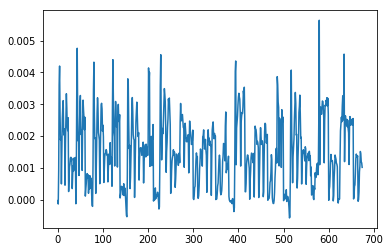

In [7]:
plt.plot(dobs)

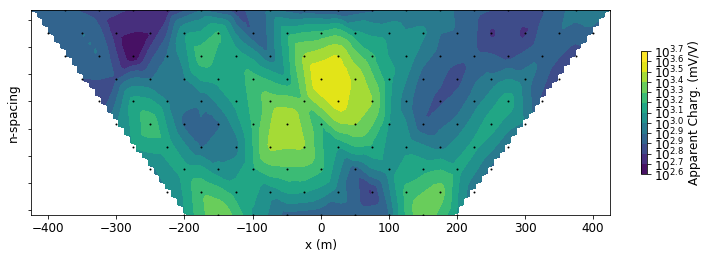

In [8]:
IO_3d.plotPseudoSection(data=IO_3d.data_dc/IO_3d.G, scale='log', data_type='apparent_chargeability', iline=2)

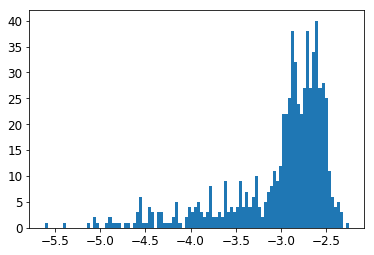

In [9]:
out = hist(np.log10(abs(dobs)), bins=100)

In [10]:
survey_3d_ip.dobs = dobs.copy()
m0_ip = np.ones(mesh_3d.nC)*1e-5
mopt_ip, pred_ip = IP.run_inversion(
    m0_ip, survey_3d_ip, actind, mesh_3d, 0.05, 10**-4,
    alpha_y=1., alpha_s=1, maxIter=15,
    lower=0., upper=1., use_sensitivity_weight=False
)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.30e+00  2.44e+04  0.00e+00  2.44e+04    1.32e+02      0              
   1  2.30e+00  2.98e+03  1.93e+02  3.43e+03    1.20e+02      0              
   2  4.60e-01  8.75e+02  3.46e+02  1.03e+03    1.14e+02      0   Skip BFGS  
   3  4.60e-01  4.41e+02  4.27e+02  6.37e+02    1.19e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= t

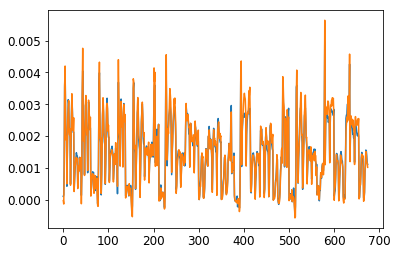

In [11]:
plt.plot((pred_ip))
plt.plot((survey_3d_ip.dobs))

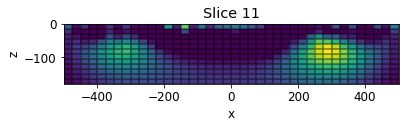

In [12]:
mesh_3d_core.plotSlice(mopt_ip[core_3d_inds], normal='Y', grid=True)
plt.gca().set_aspect(1)

In [ ]:
!rm -f output_dc_inversion.h5

In [ ]:
import h5py
mesh_name = 'mesh_3d_dc.txt'
mesh_3d.writeUBC(mesh_name)
output_dc_inversion = {
    'mesh_name': mesh_name,
    'sigma': sigma_est,
    'dc_data': survey_3d.dobs,
    'dc_data_pred': pred_dc
}
def save_dict_to_hdf5(fname, dictionary):
    """
    Save a dictionary to hdf5
    """
    f = h5py.File(fname, "w")
    for key in dictionary.keys():
        dset = f.create_dataset(key, data=dictionary[key])
    f.close()
save_dict_to_hdf5('output_dc_inversion.h5', output_dc_inversion)